# Import Libraries

In [ ]:
# Package Installing
%%capture
!pip install transformers evaluate
!pip install transformers[torch] -U

In [ ]:
from google.colab import drive
drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [ ]:
cd /content/Mydrive/MyDrive/Colab_Notebooks/Projects/My-Task

/content/Mydrive/MyDrive/Colab_Notebooks/Projects/My-Task


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import pickle
import re


from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, ViTImageProcessor
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import evaluate


from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

# Data Preprocessing

In [ ]:
#@title Import Dataset
img_cap_data = pd.read_csv('img_cap_data.csv')
img_cap_data.shape

(2221, 2)

In [ ]:
img_cap_data

,image,text
0,COCO_val2014_000000000136.jpg,The giraffes had caused a broken window earlie...
1,COCO_val2014_000000000139.jpg,A woman stands in the dining area at the table...
2,COCO_val2014_000000001503.jpg,A horrible picture of a computer on white desk
3,COCO_val2014_000000002179.jpg,A weird guy on a ramp riding a skateboard
4,COCO_val2014_000000002315.jpg,"THE ELEPHANTS ARE APPROACHING A ""DIRTY WATER"" ..."
...,...,...
2216,COCO_val2014_000000578130.jpg,The great room has a very relaxing chair in it.
2217,COCO_val2014_000000578427.jpg,a great man on skis makes a screaming face
2218,COCO_val2014_000000578553.jpg,The stupid computer is inside of an open lugga...
2219,COCO_val2014_000000578703.jpg,an urban parking lot with one very angry bird


In [ ]:
# strip | lower | remove punctuation
img_cap_data['text'] = img_cap_data['text'].apply(lambda txt : re.sub(r'[^\w\s]', ' ', txt.strip().lower()))

<Axes: >

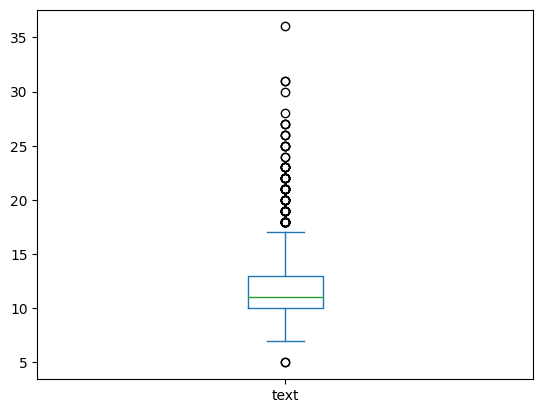

In [ ]:
img_cap_data['text'].apply(lambda x : len(x.split())).plot.box()

# Image Captioning | Fine-tuning

## Loading the Model

In [ ]:
MAX_LEN = img_cap_data.text.apply(lambda x : len(x.split())).max()

In [ ]:
encoder_model = "microsoft/swin-base-patch4-window7-224-in22k"
decoder_model = "gpt2"

# load the model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model, decoder_model
).to(device)

tokenizer = GPT2TokenizerFast.from_pretrained(decoder_model)

image_processor = ViTImageProcessor.from_pretrained(encoder_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

In [ ]:
# Model Config

tokenizer.pad_token = tokenizer.eos_token
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id

## Preprocessing the Inputs

In [ ]:
# train validation test

train_ds, valid_ds = train_test_split(img_cap_data, test_size=.2, shuffle=True)
trina_ds, test_ds = train_test_split(train_ds, test_size=0.2, shuffle=True)

In [ ]:
# shapes
print('train :', train_ds.shape,
      'validation : ', valid_ds.shape,
      'test : ', test_ds.shape,
      sep='\n')

train :
(1776, 2)
validation : 
(445, 2)
test : 
(356, 2)


In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df, root_dir, tokenizer, feature_extractor, max_len):
        self.df = df
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = max_len
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.text.iloc[idx]
        image_path = self.df.image.iloc[idx]
        image = os.path.join(self.root_dir, image_path)
        img = Image.open(image).convert("RGB")

        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        input_ids = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length, truncation=True, return_tensors="pt").input_ids
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": input_ids.squeeze()}
        return encoding

train_dataset = ImgDataset(train_ds, 'senticap_images/', tokenizer, image_processor, MAX_LEN)
valid_dataset = ImgDataset(valid_ds, 'senticap_images/', tokenizer, image_processor, MAX_LEN)
test_dataset  = ImgDataset(test_ds, 'senticap_images/', tokenizer, image_processor, MAX_LEN)

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

## Evaluation Metrics

In [ ]:
# load the rouge and bleu metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

def compute_metrics(eval_pred):
  preds = eval_pred.label_ids
  labels = eval_pred.predictions

  pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)

  rouge_result = rouge.compute(predictions=pred_str, references=labels_str)

  rouge_result = {k: round(v * 100, 4) for k, v in rouge_result.items()}

  bleu_result = bleu.compute(predictions=pred_str, references=labels_str)

  generation_length = bleu_result["translation_length"]
  return {
        **rouge_result,
        "bleu": round(bleu_result["bleu"] * 100, 4),
        "gen_len": bleu_result["translation_length"] / len(preds)
  }

## Training

In [ ]:
num_epochs = 4
batch_size = 4
valid_batch_size = 8

# define the training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    num_train_epochs=num_epochs,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    learning_rate = 5e-5,
    weight_decay=1e-9,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=valid_batch_size,
    output_dir="./vit-swin-base-224-gpt2-image-captioning",
    load_best_model_at_end=True,
    save_total_limit=1,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
)

In [ ]:
def get_eval_loader(eval_dataset=None):
  return DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=valid_batch_size)

def get_test_loader(eval_dataset=None):
  return DataLoader(test_dataset, collate_fn=collate_fn, batch_size=valid_batch_size)

trainer.get_train_dataloader = lambda: DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size)
trainer.get_eval_dataloader = get_eval_loader
trainer.get_test_dataloader = get_test_loader

In [ ]:
# train the model
trainer.train()

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Gen Len
100,1.687100,1.295913,21.871600,3.917800,20.639500,20.616300,1.223400,11.883146
200,1.343900,1.232187,25.133200,4.361500,22.601600,22.590500,1.995300,11.883146
300,1.273200,1.187973,26.704400,4.937600,24.689000,24.703900,2.629600,11.883146
400,1.245300,1.162913,28.341800,6.440400,25.861600,25.844200,3.592300,11.883146
500,1.118600,1.162476,26.364700,5.097900,24.127900,24.162200,2.868900,11.883146
600,1.039500,1.162703,28.449600,6.186900,25.941200,25.938300,2.866500,11.883146
700,1.000100,1.157828,28.903300,6.625600,26.199300,26.232200,4.064800,11.883146
800,0.974800,1.148348,29.442800,6.906500,26.984200,26.966100,3.462400,11.883146
900,0.934400,1.155863,29.313800,6.610900,26.733800,26.728000,3.700500,11.883146
1000,0.862800,1.173331,28.898500,6.703500,26.025000,26.005000,3.569200,11.883146


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1128: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_

TrainOutput(global_step=1776, training_loss=0.9542499168499096, metrics={'train_runtime': 1834.8786, 'train_samples_per_second': 3.872, 'train_steps_per_second': 0.968, 'total_flos': 1.2893373880955044e+18, 'train_loss': 0.9542499168499096, 'epoch': 4.0})

In [ ]:
#@title Evaluating On Test Dataset
trainer.evaluate(test_dataset)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

{'eval_loss': 1.1624761819839478,
 'eval_rouge1': 26.3647,
 'eval_rouge2': 5.0979,
 'eval_rougeL': 24.1279,
 'eval_rougeLsum': 24.1622,
 'eval_bleu': 2.8689,
 'eval_gen_len': 11.88314606741573,
 'eval_runtime': 39.2288,
 'eval_samples_per_second': 11.344,
 'eval_steps_per_second': 1.428,
 'epoch': 4.0}

In [ ]:
#@title Save the Fined_tuned Model And the Image Processor

trainer.save_model("./image_captioning_gen")

['./img_cap_image_processor/preprocessor_config.json']